# Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skactiveml.utils import MISSING_LABEL
from sklearn.metrics import accuracy_score
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score
from skactiveml.classifier import ParzenWindowClassifier, SklearnClassifier
from skactiveml.pool import UncertaintySampling, RandomSampling, QueryByCommittee

# Loading the Dataset

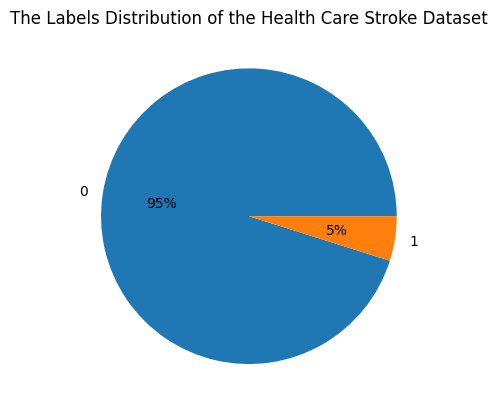

In [52]:
file_path = "/kaggle/input/stroke-prediction-dataset/healthcare-dataset-stroke-data.csv"

# Load the dataset into a pandas DataFrame
df = pd.read_csv(file_path)
df[['gender','ever_married','work_type','Residence_type','smoking_status']] = df[['gender','ever_married','work_type','Residence_type','smoking_status']].apply(lambda x: pd.factorize(x)[0])

# Handle missing values by filling them with a suitable strategy, such as mean imputation
df.fillna(df.mean(), inplace=True)

# Separate features (X) and target variable (y) after handling missing values
X = df.drop(columns=['stroke'])
y = df['stroke']

plt.pie(df['stroke'].value_counts(),labels=[0,1], autopct='%.0f%%')
plt.title("The Labels Distribution of the Health Care Stroke Dataset")
plt.show()

def annotate_confusion_matrix(matrix, ax):
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            ax.text(j, i, str(matrix[i, j]), ha='center', va='center', color='black')

# 1. Entropy Uncertainty Sampling

Training Accuracy before active learning: 0.8503496503496504

Testing Accuracy before active learning: 0.8635869565217391

F1 Score before active learning: 0.01953125

F1 Score after active learning cycle 1: 0.030054644808743168

F1 Score after active learning cycle 2: 0.03963963963963964

F1 Score after active learning cycle 3: 0.05200945626477542

F1 Score after active learning cycle 4: 0.06451612903225806

F1 Score after active learning cycle 5: 0.06707317073170732

F1 Score after active learning cycle 6: 0.06790123456790124

F1 Score after active learning cycle 7: 0.06790123456790124

F1 Score after active learning cycle 8: 0.06790123456790124

F1 Score after active learning cycle 9: 0.06790123456790124

F1 Score after active learning cycle 10: 0.06790123456790124

F1 Score after active learning cycle 11: 0.06790123456790124

F1 Score after active learning cycle 12: 0.06790123456790124

F1 Score after active learning cycle 13: 0.06790123456790124

F1 Score after active learning cyc

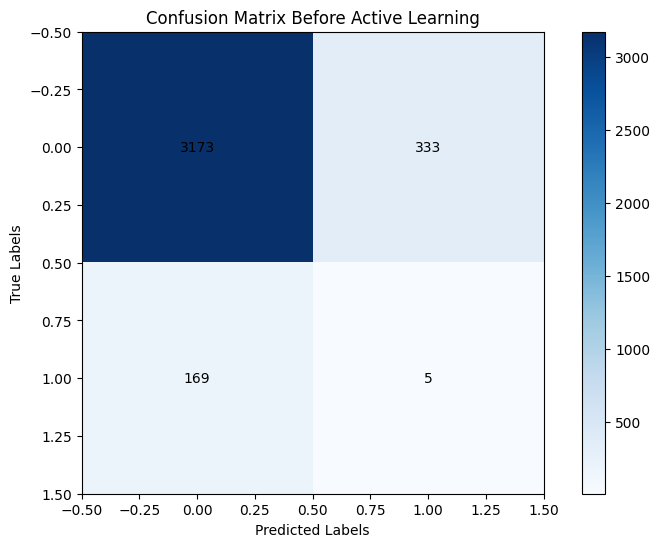

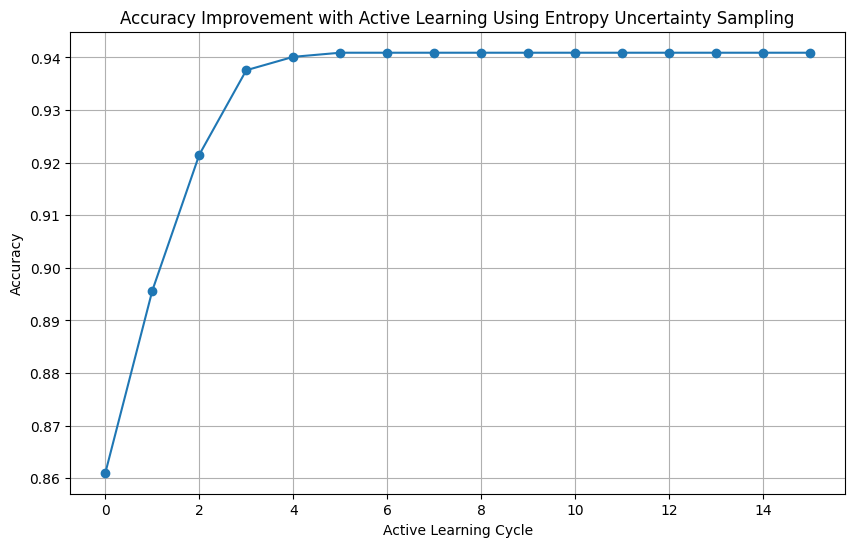

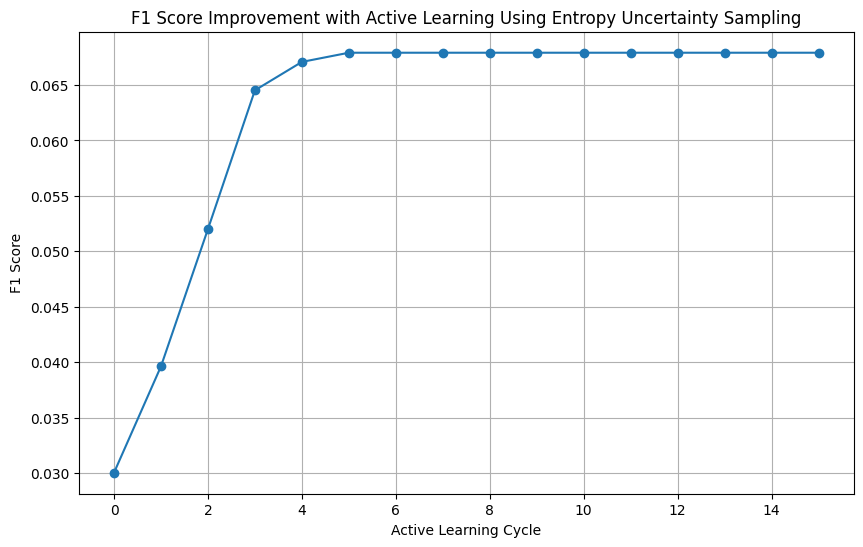

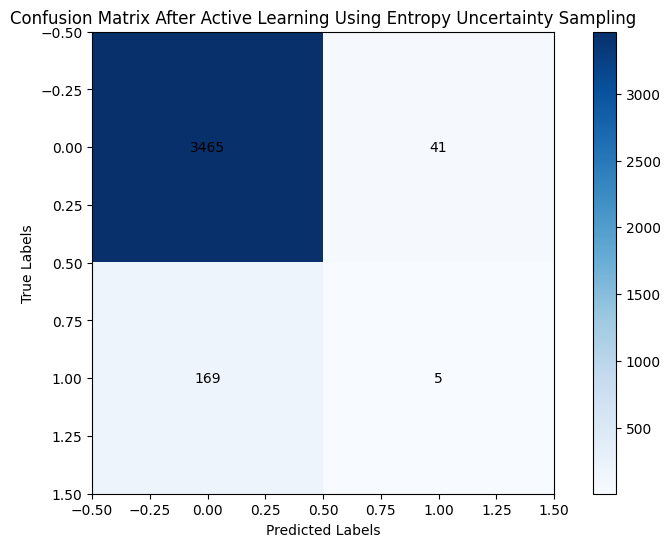

In [46]:
X_labeled, X_unlabeled, y_labeled, y_unlabeled = train_test_split(X, y, test_size=0.72, random_state=42)

y_nan = np.full(shape=y_unlabeled.shape, fill_value=MISSING_LABEL)

y_combined = np.concatenate((y_labeled, y_nan))

# Create a Parzen Window classifier
clf = ParzenWindowClassifier(classes=[0, 1], random_state=42)

# Train the classifier on the labeled data
clf.fit(X, y_combined)
            
# Evaluate the classifier on the initial labeled data
y_pred_initial = clf.predict(X_labeled)
accuracy_initial = accuracy_score(y_labeled, y_pred_initial)
print("Training Accuracy before active learning:", accuracy_initial)

y_pred_test1 = clf.predict(X_unlabeled)
accuracy_active1 = accuracy_score(y_unlabeled, y_pred_test1)
print("\nTesting Accuracy before active learning:", accuracy_active1)

f1_active = f1_score(y_unlabeled, y_pred_test1, average='binary')
print("\nF1 Score before active learning:", f1_active)

ConfusinMatrix_active = confusion_matrix(y_unlabeled, y_pred_test1)

plt.figure(figsize=(10, 6))
plt.imshow(ConfusinMatrix_active, interpolation='nearest', cmap='Blues')
plt.colorbar()
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Before Active Learning')
annotate_confusion_matrix(ConfusinMatrix_active, plt.gca())

# Active learning loop
batch_size = 230
n_cycles = int((X_unlabeled.shape[0]/batch_size))
qs = UncertaintySampling(method='entropy', random_state=42)
entropy_accuracy_values = []
entropy_f1scores = []

for c in range(n_cycles):
    
    # Fit the classifier on the updated labeled data
    clf.fit(X, y_combined)

    # Query the next instances.
    query_idx = qs.query(X=X, y=y_combined, batch_size=batch_size, clf=clf)

    # Label the queried instances.
    y_combined[query_idx] = y[query_idx]
    y_pred_active = clf.predict(X)
    accuracy_active = accuracy_score(y, y_pred_active)
    entropy_accuracy_values.append(accuracy_active)
    
    f1_active1 = f1_score(y, y_pred_active, average='binary')
    entropy_f1scores.append(f1_active1)

    print(f"\nF1 Score after active learning cycle {c+1}: {f1_active1}")

# Testing the classifier
y_pred_test = clf.predict(X_unlabeled)

accuracy_active1 = accuracy_score(y_unlabeled, y_pred_test)
print("\nTesting Accuracy:", accuracy_active1)

final_f1score = f1_score(y_unlabeled, y_pred_test, average='binary')
print("\nTesting F1 Score:", final_f1score)

ConfusinMatrix_active1 = confusion_matrix(y_unlabeled, y_pred_test)

# Plotting accuracy over cycles
plt.figure(figsize=(10, 6))
plt.plot(range(len(entropy_accuracy_values)), entropy_accuracy_values, marker='o')
plt.xlabel('Active Learning Cycle')
plt.ylabel('Accuracy')
plt.title('Accuracy Improvement with Active Learning Using Entropy Uncertainty Sampling')
plt.grid(True)

plt.figure(figsize=(10, 6))
plt.plot(range(len(entropy_f1scores)), entropy_f1scores, marker='o')
plt.xlabel('Active Learning Cycle')
plt.ylabel('F1 Score')
plt.title('F1 Score Improvement with Active Learning Using Entropy Uncertainty Sampling')
plt.grid(True)

plt.figure(figsize=(10, 6))
plt.imshow(ConfusinMatrix_active1, interpolation='nearest', cmap='Blues')
plt.colorbar()
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix After Active Learning Using Entropy Uncertainty Sampling')
annotate_confusion_matrix(ConfusinMatrix_active1, plt.gca())

plt.show()

# 2. Random Sampling

Training Accuracy before active learning: 0.8503496503496504

Testing Accuracy before active learning: 0.8635869565217391

F1 Score before active learning: 0.01953125

F1 Score after active learning cycle 1: 0.030054644808743168

F1 Score after active learning cycle 2: 0.03600654664484452

F1 Score after active learning cycle 3: 0.03907637655417407

F1 Score after active learning cycle 4: 0.04238921001926783

F1 Score after active learning cycle 5: 0.04536082474226804

F1 Score after active learning cycle 6: 0.047311827956989246

F1 Score after active learning cycle 7: 0.05128205128205128

F1 Score after active learning cycle 8: 0.054862842892768084

F1 Score after active learning cycle 9: 0.05641025641025641

F1 Score after active learning cycle 10: 0.05898123324396784

F1 Score after active learning cycle 11: 0.06060606060606061

F1 Score after active learning cycle 12: 0.0623229461756374

F1 Score after active learning cycle 13: 0.06358381502890173

F1 Score after active learning cy

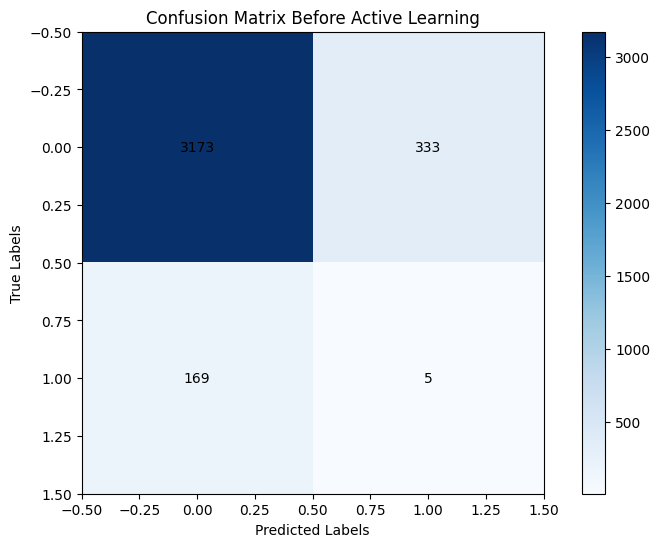

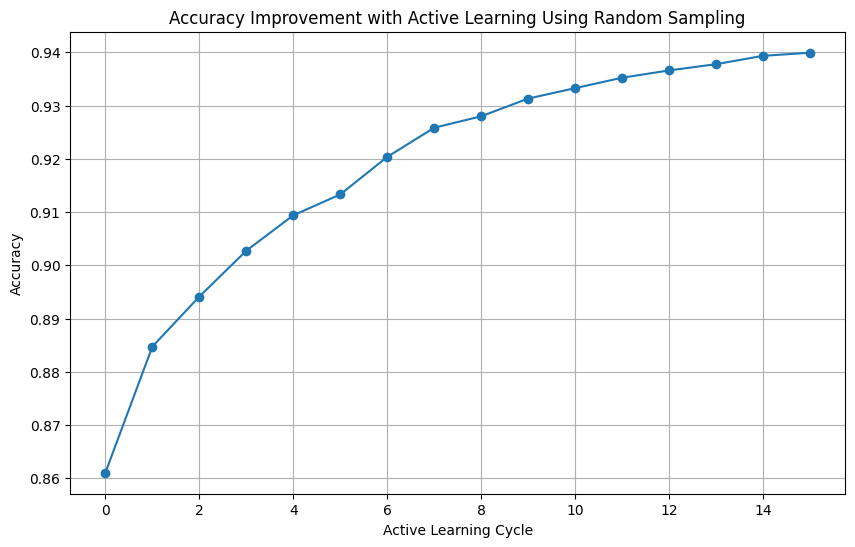

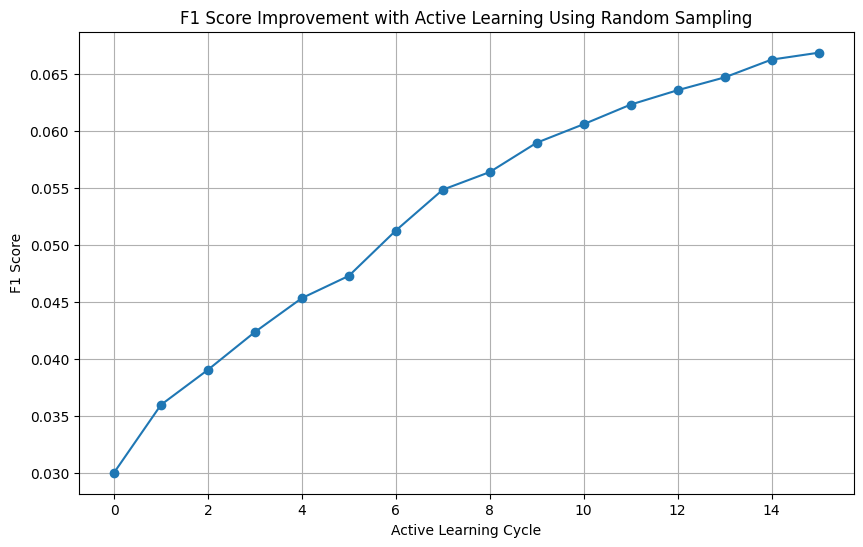

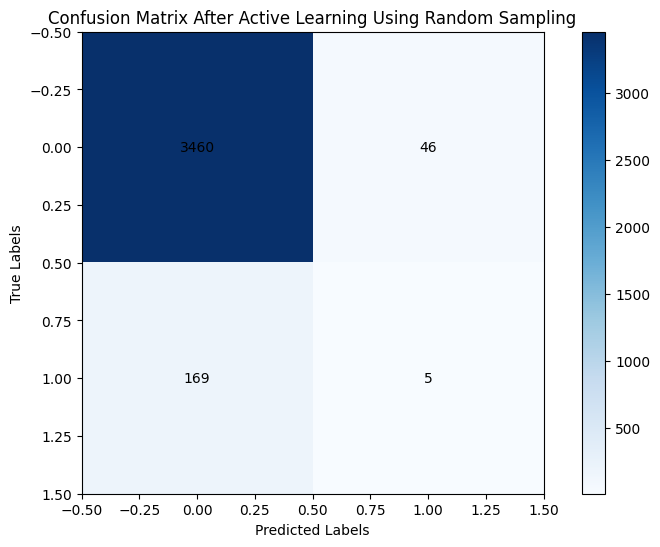

In [48]:
X_labeled, X_unlabeled, y_labeled, y_unlabeled = train_test_split(X, y, test_size=0.72, random_state=42)

y_nan = np.full(shape=y_unlabeled.shape, fill_value=MISSING_LABEL)

y_combined = np.concatenate((y_labeled, y_nan))

# Create a Parzen Window classifier
clf = ParzenWindowClassifier(classes=[0, 1], random_state=42)

# Train the classifier on the labeled data
clf.fit(X, y_combined)
            
# Evaluate the classifier on the initial labeled data
y_pred_initial = clf.predict(X_labeled)
accuracy_initial = accuracy_score(y_labeled, y_pred_initial)
print("Training Accuracy before active learning:", accuracy_initial)

y_pred_test1 = clf.predict(X_unlabeled)
accuracy_active1 = accuracy_score(y_unlabeled, y_pred_test1)
print("\nTesting Accuracy before active learning:", accuracy_active1)

f1_active = f1_score(y_unlabeled, y_pred_test1, average='binary')
print("\nF1 Score before active learning:", f1_active)

ConfusinMatrix_active = confusion_matrix(y_unlabeled, y_pred_test1)

plt.figure(figsize=(10, 6))
plt.imshow(ConfusinMatrix_active, interpolation='nearest', cmap='Blues')
plt.colorbar()
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Before Active Learning')
annotate_confusion_matrix(ConfusinMatrix_active, plt.gca())

# Active learning loop
batch_size = 230
n_cycles = int((X_unlabeled.shape[0]/batch_size))
qs = RandomSampling(random_state=42)
random_accuracy_values = []
random_f1scores = []

for c in range(n_cycles):
    
    # Fit the classifier on the updated labeled data
    clf.fit(X, y_combined)

    # Query the next instances.
    query_idx = qs.query(X=X, y=y_combined, batch_size=batch_size)

    # Label the queried instances.
    y_combined[query_idx] = y[query_idx]
    y_pred_active = clf.predict(X)
    accuracy_active = accuracy_score(y, y_pred_active)
    random_accuracy_values.append(accuracy_active)
    
    f1_active1 = f1_score(y, y_pred_active, average='binary')
    random_f1scores.append(f1_active1)

    print(f"\nF1 Score after active learning cycle {c+1}: {f1_active1}")

# Testing the classifier
y_pred_test = clf.predict(X_unlabeled)

accuracy_active1 = accuracy_score(y_unlabeled, y_pred_test)
print("\nTesting Accuracy:", accuracy_active1)

final_f1score = f1_score(y_unlabeled, y_pred_test, average='binary')
print("\nTesting F1 Score:", final_f1score)

ConfusinMatrix_active1 = confusion_matrix(y_unlabeled, y_pred_test)

# Plotting accuracy over cycles
plt.figure(figsize=(10, 6))
plt.plot(range(len(random_accuracy_values)), random_accuracy_values, marker='o')
plt.xlabel('Active Learning Cycle')
plt.ylabel('Accuracy')
plt.title('Accuracy Improvement with Active Learning Using Random Sampling')
plt.grid(True)

plt.figure(figsize=(10, 6))
plt.plot(range(len(random_f1scores)), random_f1scores, marker='o')
plt.xlabel('Active Learning Cycle')
plt.ylabel('F1 Score')
plt.title('F1 Score Improvement with Active Learning Using Random Sampling')
plt.grid(True)

plt.figure(figsize=(10, 6))
plt.imshow(ConfusinMatrix_active1, interpolation='nearest', cmap='Blues')
plt.colorbar()
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix After Active Learning Using Random Sampling')
annotate_confusion_matrix(ConfusinMatrix_active1, plt.gca())

plt.show()

# 3. Query-By-Committee 

Accuracy before active learning: 0.9027972027972028

Testing Accuracy before active learning: 0.9130434782608695

F1 Score before active learning: 0.03614457831325302

F1 Score after active learning cycle 1: 0.042643923240938165

F1 Score after active learning cycle 2: 0.05830903790087464

F1 Score after active learning cycle 3: 0.06329113924050632

F1 Score after active learning cycle 4: 0.06349206349206349

F1 Score after active learning cycle 5: 0.05844155844155844

F1 Score after active learning cycle 6: 0.046511627906976744

F1 Score after active learning cycle 7: 0.07028753993610223

F1 Score after active learning cycle 8: 0.04560260586319218

F1 Score after active learning cycle 9: 0.05405405405405406

F1 Score after active learning cycle 10: 0.06493506493506493

F1 Score after active learning cycle 11: 0.0588235294117647

F1 Score after active learning cycle 12: 0.05844155844155844

F1 Score after active learning cycle 13: 0.07006369426751592

F1 Score after active learning cyc

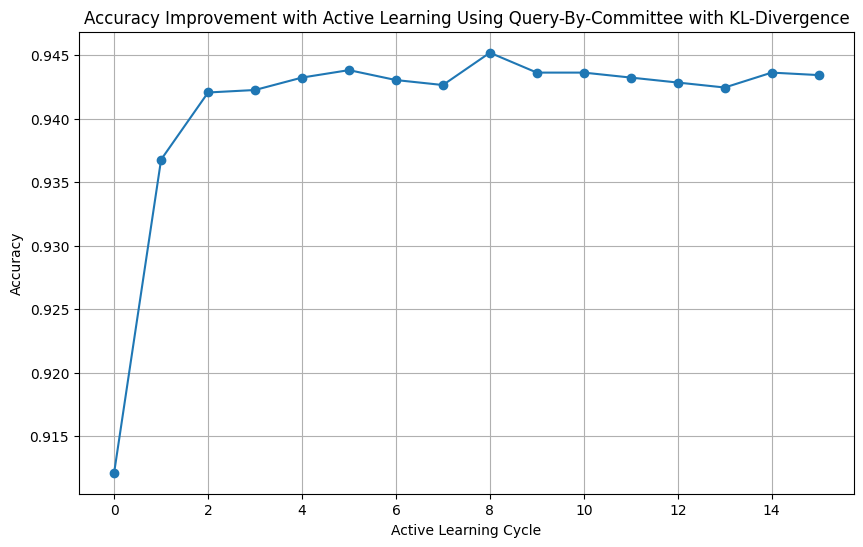

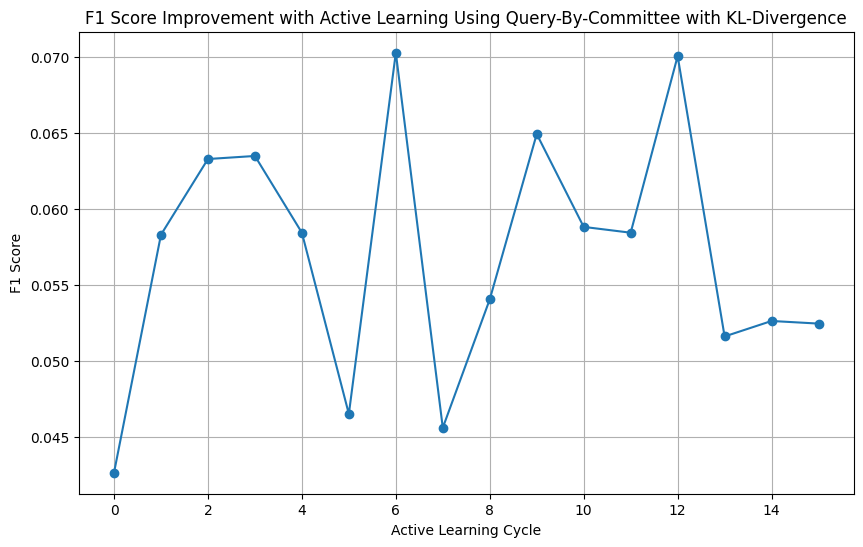

In [51]:
X_labeled, X_unlabeled, y_labeled, y_unlabeled = train_test_split(X, y, test_size=0.72, random_state=42)

y_nan = np.full(shape=y_unlabeled.shape, fill_value=MISSING_LABEL)

y_combined = np.concatenate((y_labeled, y_nan))

# Create a Parzen Window classifier
clf = SklearnClassifier(BaggingClassifier(ParzenWindowClassifier()), classes=[0, 1], random_state=42)

# Train the classifier on the labeled data
clf.fit(X, y_combined)

# Evaluate the classifier on the initial labeled data
y_pred_initial = clf.predict(X_labeled)
accuracy_initial = accuracy_score(y_labeled, y_pred_initial)
print("Accuracy before active learning:", accuracy_initial)

y_pred_test1 = clf.predict(X_unlabeled)
# print(y_pred_test)
accuracy_active1 = accuracy_score(y_unlabeled, y_pred_test1)
print("\nTesting Accuracy before active learning:", accuracy_active1)

f1_active = f1_score(y_unlabeled, y_pred_test1, average='binary')
print("\nF1 Score before active learning:", f1_active)

# Active learning loop
batch_size = 230
n_cycles = int((X_unlabeled.shape[0]/batch_size))
qs = QueryByCommittee(method='KL_divergence', random_state=42)
query_accuracy_values = []
query_f1scores = []

for c in range(n_cycles):
    
    # Fit the classifier on the updated labeled data
    clf.fit(X, y_combined)

    # Query the next instances.
    query_idx = qs.query(X=X, y=y_combined, ensemble=clf, batch_size=batch_size)

    # Label the queried instances.
    y_combined[query_idx] = y[query_idx]
    y_pred_active = clf.predict(X)
    accuracy_active = accuracy_score(y, y_pred_active)
    query_accuracy_values.append(accuracy_active)

    f1_active1 = f1_score(y, y_pred_active, average='binary')
    query_f1scores.append(f1_active1)

    print(f"\nF1 Score after active learning cycle {c+1}: {f1_active1}")

# Testing the classifier
y_pred_test = clf.predict(X_unlabeled)
accuracy_active1 = accuracy_score(y_unlabeled, y_pred_test)
print("\nTesting Accuracy:", accuracy_active1)

# Plotting accuracy over cycles
plt.figure(figsize=(10, 6))
plt.plot(range(len(query_accuracy_values)), query_accuracy_values, marker='o')
plt.xlabel('Active Learning Cycle')
plt.ylabel('Accuracy')
plt.title('Accuracy Improvement with Active Learning Using Query-By-Committee with KL-Divergence')
plt.grid(True)

plt.figure(figsize=(10, 6))
plt.plot(range(len(query_f1scores)), query_f1scores, marker='o')
plt.xlabel('Active Learning Cycle')
plt.ylabel('F1 Score')
plt.title('F1 Score Improvement with Active Learning Using Query-By-Committee with KL-Divergence')
plt.grid(True)

plt.show()

# 4. Least Confidence Uncertainty Sampling

Training Accuracy before active learning: 0.8503496503496504

Testing Accuracy before active learning: 0.8635869565217391

F1 Score before active learning: 0.01953125

F1 Score after active learning cycle 1: 0.030054644808743168

F1 Score after active learning cycle 2: 0.03963963963963964

F1 Score after active learning cycle 3: 0.04814004376367615

F1 Score after active learning cycle 4: 0.05301204819277108

F1 Score after active learning cycle 5: 0.055696202531645575

F1 Score after active learning cycle 6: 0.058510638297872335

F1 Score after active learning cycle 7: 0.05978260869565218

F1 Score after active learning cycle 8: 0.061624649859943974

F1 Score after active learning cycle 9: 0.06303724928366762

F1 Score after active learning cycle 10: 0.06376811594202898

F1 Score after active learning cycle 11: 0.06470588235294117

F1 Score after active learning cycle 12: 0.06547619047619048

F1 Score after active learning cycle 13: 0.06626506024096386

F1 Score after active learning 

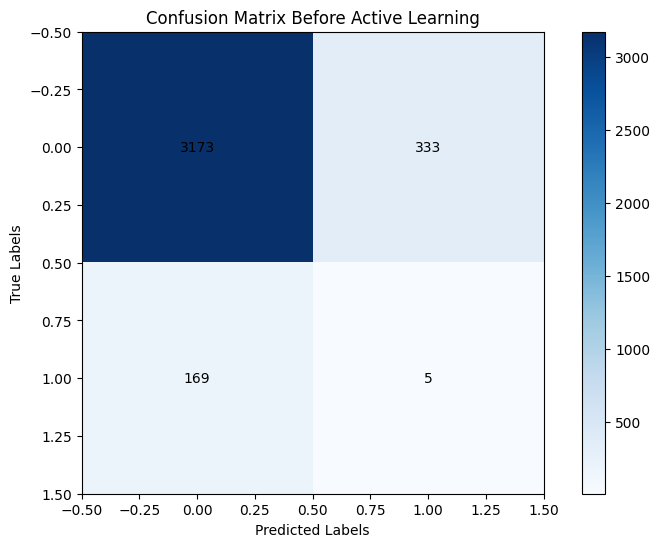

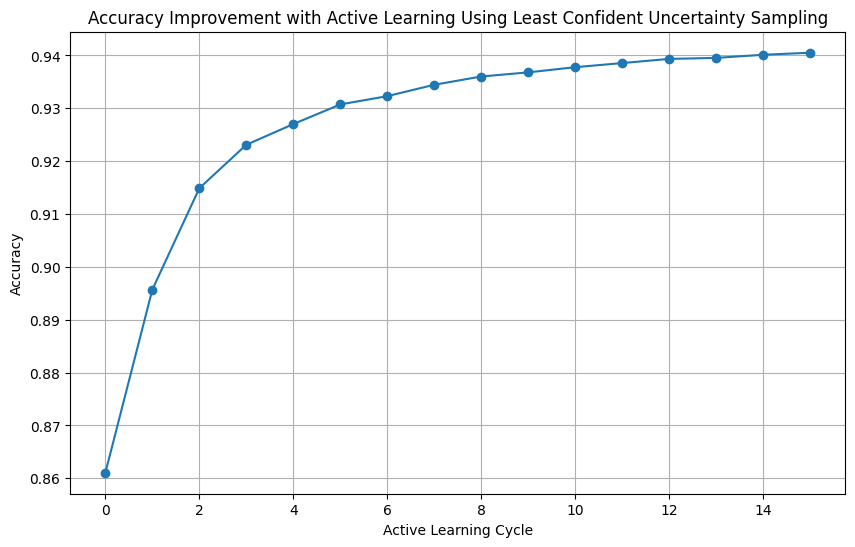

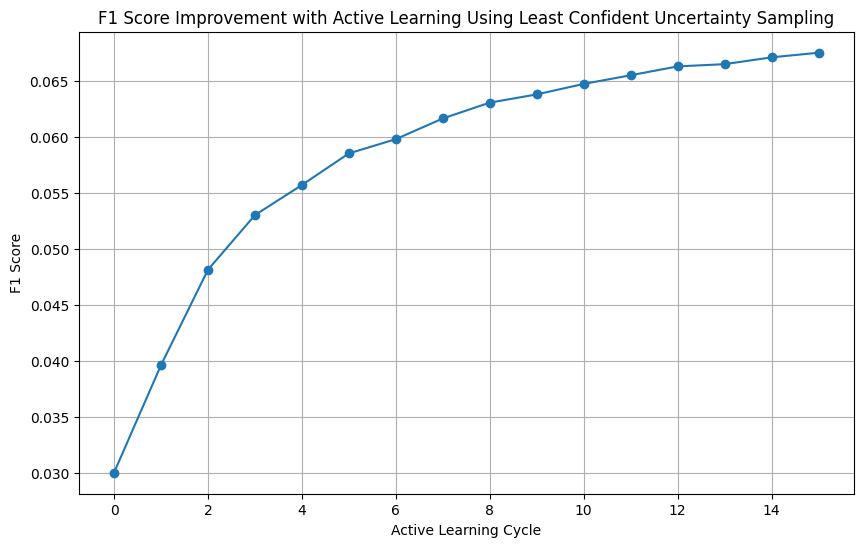

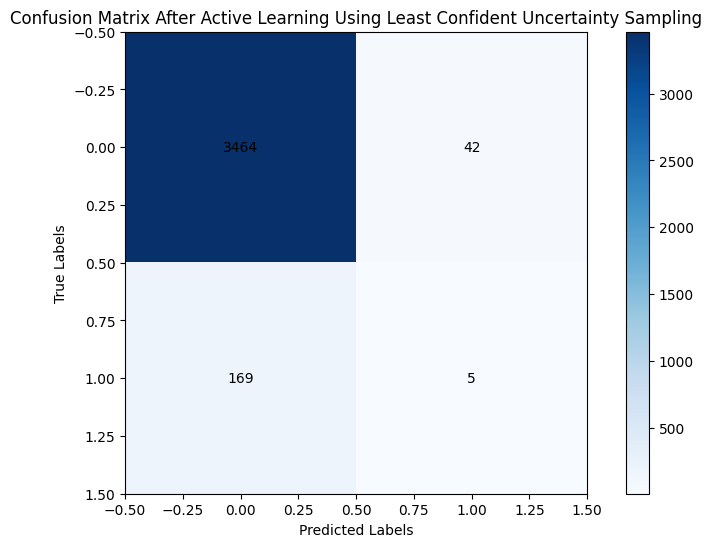

In [53]:
X_labeled, X_unlabeled, y_labeled, y_unlabeled = train_test_split(X, y, test_size=0.72, random_state=42)

y_nan = np.full(shape=y_unlabeled.shape, fill_value=MISSING_LABEL)

y_combined = np.concatenate((y_labeled, y_nan))

# Create a Parzen Window classifier
clf = ParzenWindowClassifier(classes=[0, 1], random_state=42)

# Train the classifier on the labeled data
clf.fit(X, y_combined)
            
# Evaluate the classifier on the initial labeled data
y_pred_initial = clf.predict(X_labeled)
accuracy_initial = accuracy_score(y_labeled, y_pred_initial)
print("Training Accuracy before active learning:", accuracy_initial)

y_pred_test1 = clf.predict(X_unlabeled)
accuracy_active1 = accuracy_score(y_unlabeled, y_pred_test1)
print("\nTesting Accuracy before active learning:", accuracy_active1)

f1_active = f1_score(y_unlabeled, y_pred_test1, average='binary')
print("\nF1 Score before active learning:", f1_active)

ConfusinMatrix_active = confusion_matrix(y_unlabeled, y_pred_test1)

plt.figure(figsize=(10, 6))
plt.imshow(ConfusinMatrix_active, interpolation='nearest', cmap='Blues')
plt.colorbar()
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Before Active Learning')
annotate_confusion_matrix(ConfusinMatrix_active, plt.gca())

# Active learning loop
batch_size = 230
n_cycles = int((X_unlabeled.shape[0]/batch_size))
qs = UncertaintySampling(method='least_confident', random_state=42)
least_accuracy_values = []
least_f1scores = []

for c in range(n_cycles):
    
    # Fit the classifier on the updated labeled data
    clf.fit(X, y_combined)

    # Query the next instances.
    query_idx = qs.query(X=X, y=y_combined, batch_size=batch_size, clf=clf)

    # Label the queried instances.
    y_combined[query_idx] = y[query_idx]
    y_pred_active = clf.predict(X)
    accuracy_active = accuracy_score(y, y_pred_active)
    least_accuracy_values.append(accuracy_active)
    
    f1_active1 = f1_score(y, y_pred_active, average='binary')
    least_f1scores.append(f1_active1)

    print(f"\nF1 Score after active learning cycle {c+1}: {f1_active1}")

# Testing the classifier
y_pred_test = clf.predict(X_unlabeled)

accuracy_active1 = accuracy_score(y_unlabeled, y_pred_test)
print("\nTesting Accuracy:", accuracy_active1)

final_f1score = f1_score(y_unlabeled, y_pred_test, average='binary')
print("\nTesting F1 Score:", final_f1score)

ConfusinMatrix_active1 = confusion_matrix(y_unlabeled, y_pred_test)

# Plotting accuracy over cycles
plt.figure(figsize=(10, 6))
plt.plot(range(len(least_accuracy_values)), least_accuracy_values, marker='o')
plt.xlabel('Active Learning Cycle')
plt.ylabel('Accuracy')
plt.title('Accuracy Improvement with Active Learning Using Least Confident Uncertainty Sampling')
plt.grid(True)

plt.figure(figsize=(10, 6))
plt.plot(range(len(least_f1scores)), least_f1scores, marker='o')
plt.xlabel('Active Learning Cycle')
plt.ylabel('F1 Score')
plt.title('F1 Score Improvement with Active Learning Using Least Confident Uncertainty Sampling')
plt.grid(True)

plt.figure(figsize=(10, 6))
plt.imshow(ConfusinMatrix_active1, interpolation='nearest', cmap='Blues')
plt.colorbar()
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix After Active Learning Using Least Confident Uncertainty Sampling')
annotate_confusion_matrix(ConfusinMatrix_active1, plt.gca())

plt.show()

# Visualization for all methods

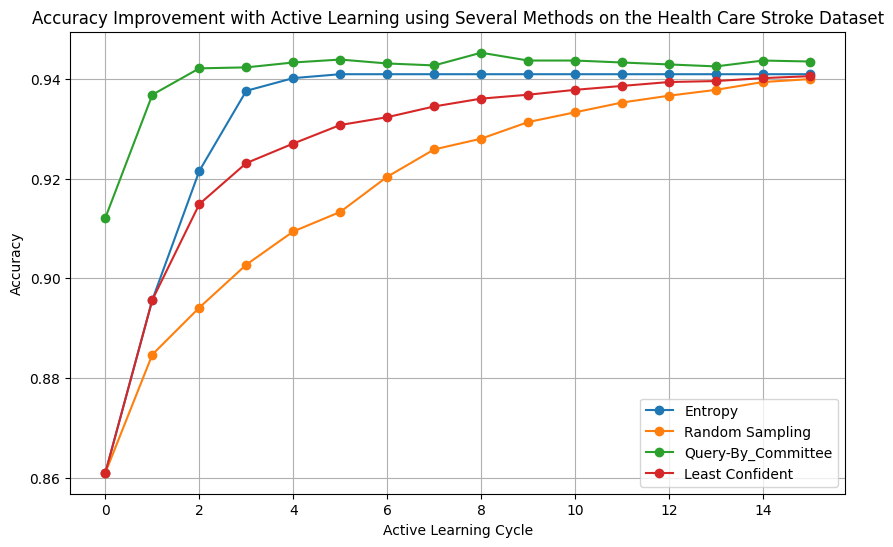

In [54]:
plt.figure(figsize=(10, 6))

plt.plot(range(len(entropy_accuracy_values)), entropy_accuracy_values, marker='o', label='Entropy')

plt.plot(range(len(random_accuracy_values)), random_accuracy_values, marker='o', label='Random Sampling')

plt.plot(range(len(query_accuracy_values)), query_accuracy_values, marker='o', label='Query-By_Committee')

plt.plot(range(len(least_accuracy_values)), least_accuracy_values, marker='o', label='Least Confident')

plt.xlabel('Active Learning Cycle')
plt.ylabel('Accuracy')
plt.title('Accuracy Improvement with Active Learning using Several Methods on the Health Care Stroke Dataset')
plt.grid(True)
plt.legend()
plt.show()

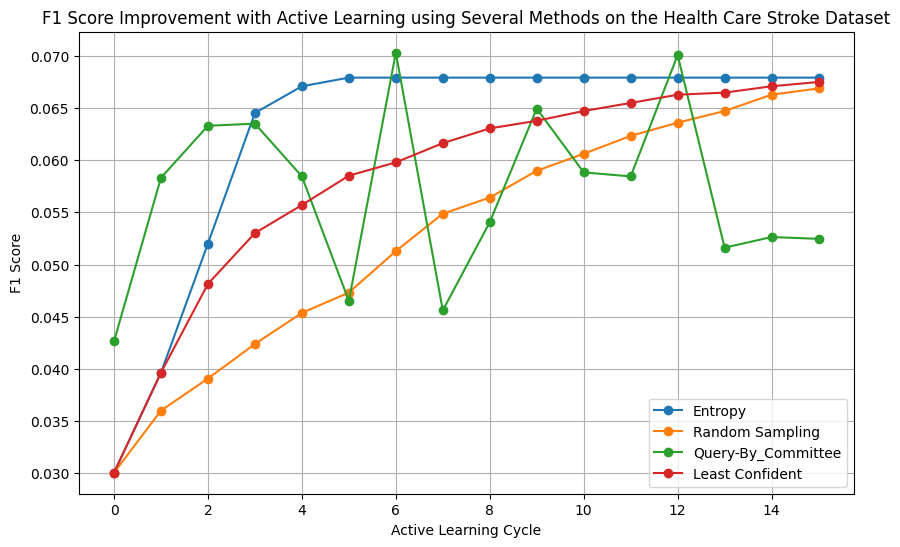

In [55]:
plt.figure(figsize=(10, 6))

plt.plot(range(len(entropy_f1scores)), entropy_f1scores, marker='o', label='Entropy')

plt.plot(range(len(random_f1scores)), random_f1scores, marker='o', label='Random Sampling')

plt.plot(range(len(query_f1scores)), query_f1scores, marker='o', label='Query-By_Committee')

plt.plot(range(len(least_f1scores)), least_f1scores, marker='o', label='Least Confident')

plt.xlabel('Active Learning Cycle')
plt.ylabel('F1 Score')
plt.title('F1 Score Improvement with Active Learning using Several Methods on the Health Care Stroke Dataset')
plt.grid(True)
plt.legend()
plt.show()